In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import sys
sys.path.append("../src/")
from structures import ConventionalCNN
from dataloader import loadCAMELS, split_expanded_dataset, split_expanded_dataset_from_json

dtype = torch.float32
torch.set_default_dtype(dtype)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Config
batch_size = 64
individual = False

Using device: cuda


## Helper Functions

In [6]:
import gc
from pathlib import Path

def clear_memory():
    """Clear GPU and CPU memory."""
    gc.collect()
    torch.cuda.empty_cache()


def log_normalize(arr, individual=False, ref_stats=None):
    """Log-scale then normalize by mean/std."""
    arr = np.log10(arr)
    if ref_stats:
        mean_val, std_val = ref_stats
    else:
        if individual:
            mean_val = arr.mean(axis=(1, 2), keepdims=True)
            std_val = arr.std(axis=(1, 2), keepdims=True)
        else:
            mean_val, std_val = arr.mean(), arr.std()
    return (arr - mean_val) / std_val, (mean_val, std_val)


def _apply_sb35_windowing(data: np.ndarray, step: int = 10, length: int = 5) -> np.ndarray:
    """Match SB35_half/cutout sampling: take 5 frames every 10."""
    arr = np.arange(data.shape[0])
    starts = np.arange(0, len(arr) - length + 1, step)
    idx = (starts[:, None] + np.arange(length)[None, :]).reshape(-1)
    return data[idx]


def _apply_crop(data: np.ndarray, crop: str = "tl") -> np.ndarray:
    h, w = data.shape[1], data.shape[2]
    hh, ww = h // 2, w // 2
    if crop == "tl":
        return data[:, :hh, :ww]
    if crop == "tr":
        return data[:, :hh, ww:]
    if crop == "bl":
        return data[:, hh:, :ww]
    if crop == "br":
        return data[:, hh:, ww:]
    raise ValueError(f"Unknown crop: {crop}")


def make_test_loader(data_norm, labels, chunk_size, splits_dir=None, shuffle_loader=False):
    """Create test DataLoader using deterministic JSON splits."""
    tensor = torch.tensor(data_norm, dtype=dtype)
    _, _, test_set = split_expanded_dataset_from_json(tensor, labels, chunk_size=chunk_size, splits_dir=splits_dir)
    return DataLoader(test_set, batch_size=batch_size, shuffle=shuffle_loader)


def load_model_pair(om_path, sig_path, input_shape=(256, 256)):
    """Load Om and Sig8 model pair."""
    model_om = ConventionalCNN(input_shape=input_shape, output_shape=1, H=16, output_positive=True).to(device)
    model_sig = ConventionalCNN(input_shape=input_shape, output_shape=1, H=16, output_positive=True).to(device)
    model_om.load_state_dict(torch.load(om_path, map_location=device, weights_only=True))
    model_sig.load_state_dict(torch.load(sig_path, map_location=device, weights_only=True))
    return model_om, model_sig


def get_predictions(model_om, model_sig, val_loader, minmax):
    """Run inference and return (truths, predictions, n_dims)."""
    model_om.eval()
    model_sig.eval()
    preds_om, preds_sig, truths = [], [], []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            preds_om.append(model_om(inputs).cpu())
            preds_sig.append(model_sig(inputs).cpu())
            truths.append(targets.cpu())
            del inputs

    preds = np.c_[torch.cat(preds_om).numpy(), torch.cat(preds_sig).numpy()]
    truths = torch.cat(truths).numpy()
    del preds_om, preds_sig
    clear_memory()

    # Denormalize predictions
    preds = preds * (minmax[:2, 1] - minmax[:2, 0]) + minmax[:2, 0]

    mse = ((preds - truths) ** 2).mean(axis=0)
    print(f"  MSE: Om={mse[0]:.4e}, Sig8={mse[1]:.4e}")
    return truths, preds, 2


def _metrics_point(y_true, y_pred, y_sigma=None, eps=1e-12):
    """Compute R^2, epsilon (mean abs relative error), RMSE, and reduced chi-square."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    resid = y_pred - y_true

    ss_res = np.sum(resid ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2) + eps
    r2 = 1.0 - ss_res / ss_tot

    rmse = np.sqrt(np.mean(resid ** 2))

    denom = np.maximum(np.abs(y_true), eps)
    eps_rel = np.mean(np.abs(resid) / denom)  # dimensionless

    if y_sigma is None:
        chi2_red = np.nan
    else:
        y_sigma = np.maximum(np.asarray(y_sigma), eps)
        chi2 = np.sum((resid / y_sigma) ** 2)
        dof = max(int(y_true.size) - 1, 1)
        chi2_red = chi2 / dof

    return r2, eps_rel, rmse, chi2_red


def _metrics_with_uncertainty(y_true, y_pred, y_sigma=None, n_boot=200, seed=0):
    """Return (mean, std) for each metric via bootstrap over simulations."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_sigma is not None:
        y_sigma = np.asarray(y_sigma)

    n = y_true.shape[0]
    if n <= 1:
        r2, eps_rel, rmse, chi2_red = _metrics_point(y_true, y_pred, y_sigma=y_sigma)
        return (r2, 0.0), (eps_rel, 0.0), (rmse, 0.0), (chi2_red, 0.0)

    rng = np.random.default_rng(seed)
    samples = np.empty((n_boot, 4), dtype=float)

    for b in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yt = y_true[idx]
        yp = y_pred[idx]
        ys = y_sigma[idx] if y_sigma is not None else None
        samples[b] = _metrics_point(yt, yp, y_sigma=ys)

    means = samples.mean(axis=0)
    stds = samples.std(axis=0, ddof=1)
    return (means[0], stds[0]), (means[1], stds[1]), (means[2], stds[2]), (means[3], stds[3])


def plot_comparison(data, chunk_size, title, num_samples=200, n_boot=200, seed=0):
    """Plot truth vs prediction with score box showing mean ± std of metrics."""
    truths, preds, _ = data
    target_names = [r"$\Omega_m$", r"$\sigma_8$"]

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # Aggregate per-simulation stats (mean/std across chunk)
    chunks = preds.reshape(-1, chunk_size, 2)
    pred_mean = chunks.mean(axis=1)
    pred_std = chunks.std(axis=1)
    true = truths[::chunk_size]

    # limit samples for plotting + metrics
    n = min(num_samples, true.shape[0])

    for i, ax in enumerate(axs):
        x = true[:n, i]
        y = pred_mean[:n, i]
        yerr = pred_std[:n, i]

        (r2_m, r2_s), (eps_m, eps_s), (rmse_m, rmse_s), (chi2_m, chi2_s) = _metrics_with_uncertainty(
            x, y, y_sigma=yerr, n_boot=n_boot, seed=seed + i
        )

        # epsilon in percent
        eps_pct_m = 100.0 * eps_m
        eps_pct_s = 100.0 * eps_s

        lines = [
            rf"$R^2 = {r2_m:.4f} \pm {r2_s:.4f}$",
            rf"$\epsilon = ({eps_pct_m:.2f} \pm {eps_pct_s:.2f})\%$",
            rf"$\mathrm{{RMSE}} = {rmse_m:.3e} \pm {rmse_s:.3e}$",
            rf"$\chi^2 = {chi2_m:.3e} \pm {chi2_s:.3e}$",
        ]
        textstr = "\n".join(lines)

        ax.errorbar(x, y, yerr=yerr, fmt='none', capsize=2, ecolor='tab:orange', alpha=0.7)
        ax.scatter(x, y, s=4, c='k', zorder=10)
        ax.plot([x.min(), x.max()], [x.min(), x.max()], 'r--', label='Ideal')

        ax.text(
            0.95, 0.05, textstr,
            transform=ax.transAxes,
            fontsize=9,
            va='bottom',
            ha='right',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5),
        )

        ax.set_xlabel("Truth")
        ax.set_ylabel("Prediction")
        ax.set_title(target_names[i])
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)

    fig.suptitle(title, fontsize=12, fontweight='bold')
    plt.tight_layout()
    return fig


def compute_stats(data):
    """Compute bias and scatter for Om and Sig8."""
    truths, preds, _ = data
    return {
        'bias_om': np.mean(truths[:, 0] - preds[:, 0]),
        'scatter_om': np.std(truths[:, 0] - preds[:, 0]),
        'bias_sig': np.mean(truths[:, 1] - preds[:, 1]),
        'scatter_sig': np.std(truths[:, 1] - preds[:, 1]),
    }


def compute_scorebox_scores(data, chunk_size, n_boot=200, seed=0):
    """Compute the same metrics shown in the plot textbox (mean ± std via bootstrap)."""
    truths, preds, _ = data

    # Per-simulation aggregation (mean/std across the chunk)
    chunks = preds.reshape(-1, chunk_size, 2)
    pred_mean = chunks.mean(axis=1)
    pred_std = chunks.std(axis=1)
    true = truths[::chunk_size]

    out = {}
    for i, tag in enumerate(['om', 'sig']):
        x = true[:, i]
        y = pred_mean[:, i]
        yerr = pred_std[:, i]

        (r2_m, r2_s), (eps_m, eps_s), (rmse_m, rmse_s), (chi2_m, chi2_s) = _metrics_with_uncertainty(
            x, y, y_sigma=yerr, n_boot=n_boot, seed=seed + i
        )

        out[f'r2_{tag}_m'] = float(r2_m)
        out[f'r2_{tag}_s'] = float(r2_s)
        out[f'eps_{tag}_pct_m'] = float(100.0 * eps_m)
        out[f'eps_{tag}_pct_s'] = float(100.0 * eps_s)
        out[f'rmse_{tag}_m'] = float(rmse_m)
        out[f'rmse_{tag}_s'] = float(rmse_s)
        out[f'chi2_{tag}_m'] = float(chi2_m)
        out[f'chi2_{tag}_s'] = float(chi2_s)

    return out


def _ensure_dir(path: Path) -> None:
    path.mkdir(parents=True, exist_ok=True)


def _slugify(name: str) -> str:
    return name.replace(":", "").replace(" ", "_").replace("|", "-").replace(">", "to").replace("/", "-")


def run_evaluation(model_om, model_sig, val_loader, minmax, chunk_size, title, num_samples=200, save_dir=None, base_name=None):
    """Run full evaluation pipeline: predict, plot, compute stats/scores, then clear."""
    print(f"\n{title}")
    data = get_predictions(model_om, model_sig, val_loader, minmax)
    fig = plot_comparison(data, chunk_size, title, num_samples=num_samples)
    if save_dir is not None:
        _ensure_dir(Path(save_dir))
        stem = _slugify(base_name or title)
        fig.savefig(Path(save_dir) / f"{stem}.png", dpi=200, bbox_inches="tight")
        fig.savefig(Path(save_dir) / f"{stem}.pdf", bbox_inches="tight")
    plt.show()
    stats = compute_stats(data)
    stats.update(compute_scorebox_scores(data, chunk_size=chunk_size, n_boot=200, seed=0))
    del data, fig
    clear_memory()
    return stats

## Load All Data

In [7]:
# Config
model_dir = "../data/models/"
chunk_sb28 = 15
chunk_sb35 = 30  # full SB35
chunk_sb35_half = 15
chunk_sb35_cutout = 15

# Output directories
results_dir = Path("../plot/cross_eval")
plots_dir = results_dir / "figures"
tables_dir = results_dir / "tables"

# Store results summary
all_results = []

## 1. SB28 → SB28


Train: SB28 | Test: SB28
  MSE: Om=1.4461e-04, Sig8=6.5467e-03


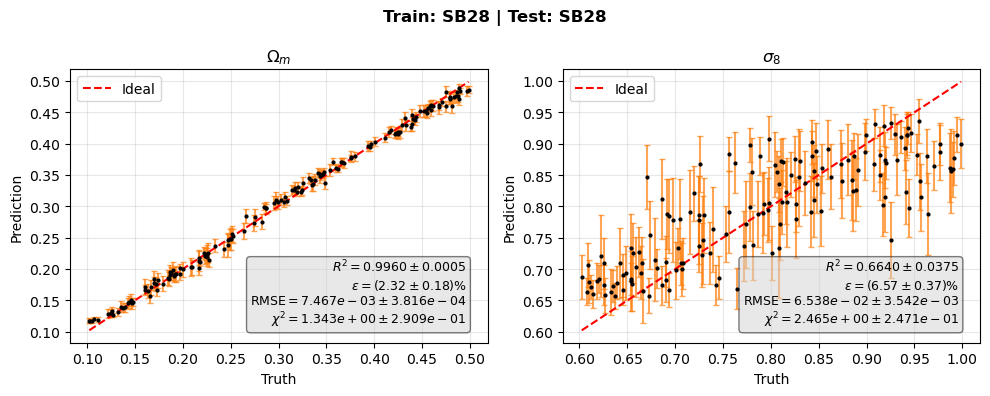

In [8]:
# Load SB28 data
_data, _labels, _minmax = loadCAMELS(field="Mtot", box="SB28", normalization=False, individual=individual)
labels = torch.tensor(_labels[:, :2], dtype=dtype)
data_norm, stats = log_normalize(_data, individual=individual)
del _data, _labels  # Free raw data

# Create loader and load models (use test split)
val_loader = make_test_loader(data_norm, labels, chunk_size=chunk_sb28)
model_om, model_sig = load_model_pair(
    model_dir + "SB28_om_best.pt",
    model_dir + "SB28_sig_best.pt",
    input_shape=(256, 256))

# Run evaluation
result = run_evaluation(model_om, model_sig, val_loader, _minmax, chunk_sb28, "Train: SB28 | Test: SB28", save_dir=plots_dir, base_name="sb28_to_sb28")
all_results.append(("SB28 → SB28", result))

# Store stats for cross-eval later
statsSB28 = stats
minmaxSB28 = _minmax

# Cleanup
del data_norm, val_loader, model_om, model_sig
clear_memory()

## 2. SB28_full → SB28_full


Train: SB28_full | Test: SB28_full
  MSE: Om=9.2128e-05, Sig8=5.7969e-03


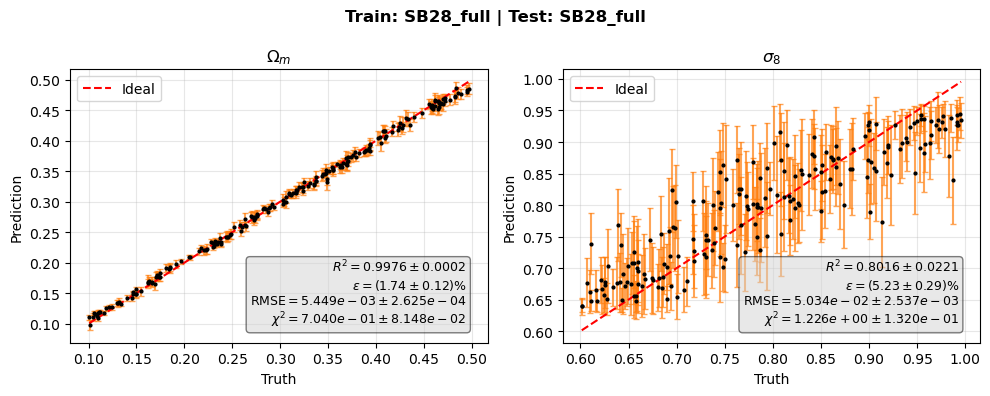

In [9]:
# Load SB28_full data
_data, _labels, _minmax = loadCAMELS(field="Mtot", box="SB28_full", normalization=False, individual=individual)
labels = torch.tensor(_labels[:, :2], dtype=dtype)
data_norm, stats = log_normalize(_data, individual=individual)
del _data, _labels

val_loader = make_test_loader(data_norm, labels, chunk_size=chunk_sb28)
model_om, model_sig = load_model_pair(
    model_dir + "SB28_full_om_best.pt",
    model_dir + "SB28_full_sig_best.pt",
    input_shape=(256, 256))

result = run_evaluation(model_om, model_sig, val_loader, _minmax, chunk_sb28, "Train: SB28_full | Test: SB28_full", save_dir=plots_dir, base_name="sb28full_to_sb28full")
all_results.append(("SB28_full → SB28_full", result))

statsSB28full = stats
minmaxSB28full = _minmax

del data_norm, val_loader, model_om, model_sig
clear_memory()

## 3. SB35 → SB35 (full 512x512)


Train: SB35 | Test: SB35
  MSE: Om=5.2838e-05, Sig8=3.0566e-03


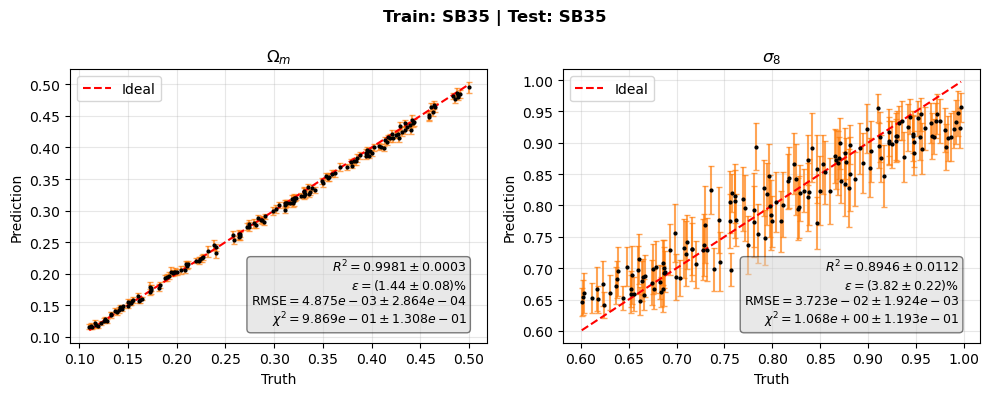

In [10]:
# Load SB35 data
_data, _labels, _minmax = loadCAMELS(field="Mtot", box="SB35", normalization=False, individual=individual)
labels = torch.tensor(_labels[:, :2], dtype=dtype)
# Normalize with SB35 stats (log10 + global mean/std)
data_norm, statsSB35 = log_normalize(_data, individual=individual)

val_loader = make_test_loader(data_norm, labels, chunk_size=chunk_sb35)
model_om, model_sig = load_model_pair(
    model_dir + "SB35_full30_om_best.pt",
    model_dir + "SB35_full30_sig_best.pt",
    input_shape=(512, 512))

result = run_evaluation(model_om, model_sig, val_loader, _minmax, chunk_sb35, "Train: SB35 | Test: SB35", save_dir=plots_dir, base_name="sb35full_to_sb35full")
all_results.append(("SB35 → SB35", result))

# Keep for cutout evaluations
labelsSB35 = labels
minmaxSB35 = _minmax
_dataSB35 = _data  # Keep raw for cutouts
statsSB35_full = statsSB35

del data_norm, val_loader, model_om, model_sig
clear_memory()

## 4. SB35_half → SB35_half


Train: SB35_half | Test: SB35_half
  MSE: Om=5.5656e-05, Sig8=3.5028e-03


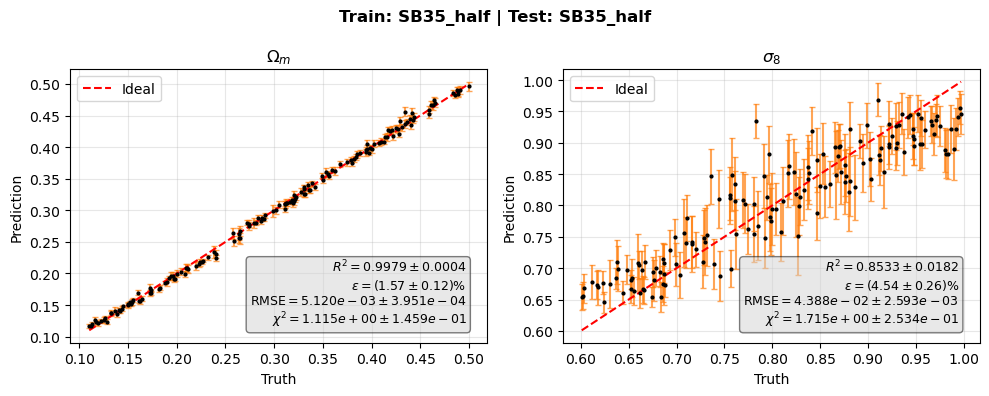

In [11]:
# Use SB35 data with SB35_half models (apply windowing to get 15 frames)
data_half = _apply_sb35_windowing(_dataSB35)
data_norm, _ = log_normalize(data_half, individual=individual, ref_stats=statsSB35_full)
val_loader = make_test_loader(data_norm, labelsSB35, chunk_size=chunk_sb35_half)

model_om, model_sig = load_model_pair(
    model_dir + "SB35_half15_om_best.pt",
    model_dir + "SB35_half15_sig_best.pt",
    input_shape=(512, 512))

result = run_evaluation(model_om, model_sig, val_loader, minmaxSB35, chunk_sb35_half, "Train: SB35_half | Test: SB35_half", save_dir=plots_dir, base_name="sb35half_to_sb35half")
all_results.append(("SB35_half → SB35_half", result))

del data_half, data_norm, val_loader, model_om, model_sig
clear_memory()

## 5. SB35_cutout → SB35_cutout


Train: SB35_cutout | Test: SB35_cutout
  MSE: Om=1.8679e-04, Sig8=5.7211e-03


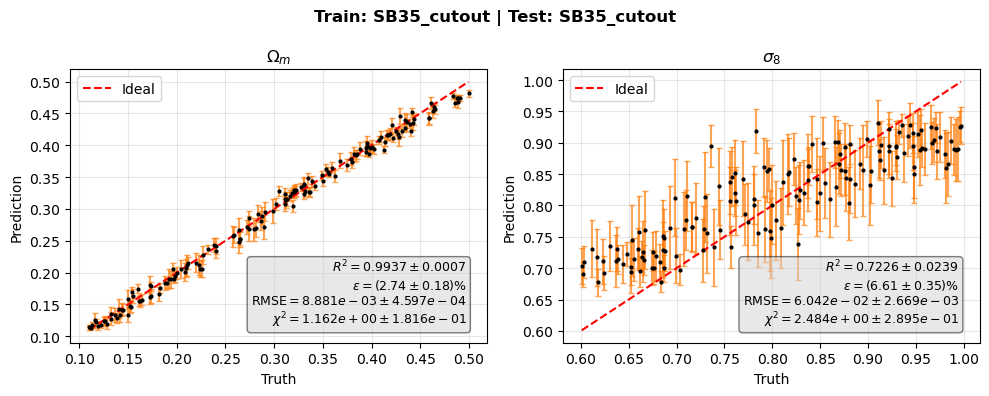

In [12]:
# SB35 cutout (256x256) with windowing (15 frames)
data_cutout = _apply_sb35_windowing(_dataSB35)
data_cutout = _apply_crop(data_cutout, crop="tl")
data_norm, statsSB35_cutout = log_normalize(data_cutout, individual=individual, ref_stats=statsSB35_full)
del data_cutout

val_loader = make_test_loader(data_norm, labelsSB35, chunk_size=chunk_sb35_cutout)
model_om, model_sig = load_model_pair(
    model_dir + "SB35_cutout15_om_best.pt",
    model_dir + "SB35_cutout15_sig_best.pt",
    input_shape=(256, 256))

result = run_evaluation(model_om, model_sig, val_loader, minmaxSB35, chunk_sb35_cutout, "Train: SB35_cutout | Test: SB35_cutout", save_dir=plots_dir, base_name="sb35cutout_to_sb35cutout")
all_results.append(("SB35_cutout → SB35_cutout", result))

# Keep models for cross-eval
model_SB35cutout_om, model_SB35cutout_sig = model_om, model_sig

del data_norm, val_loader
clear_memory()

## 6. Cross-Domain: SB28 ↔ SB35_cutout


Train: SB28 | Test: SB35_cutout
  MSE: Om=1.8434e-04, Sig8=6.1061e-03


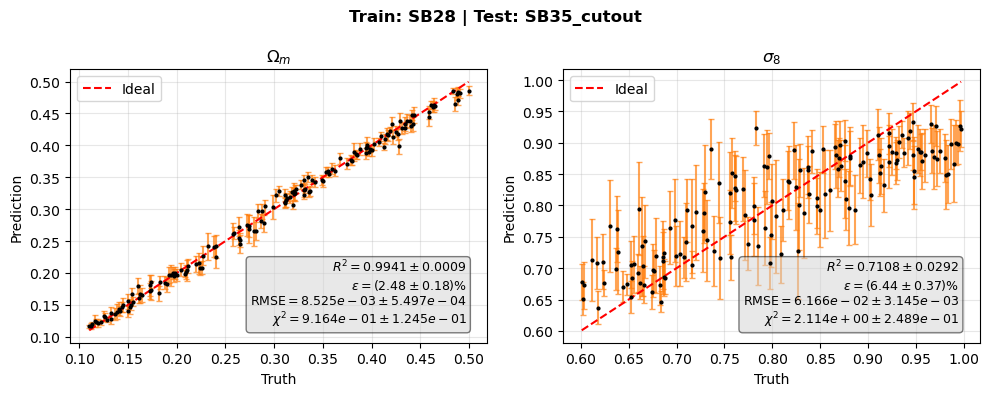


Train: SB35_cutout | Test: SB28
  MSE: Om=1.6855e-04, Sig8=6.6958e-03


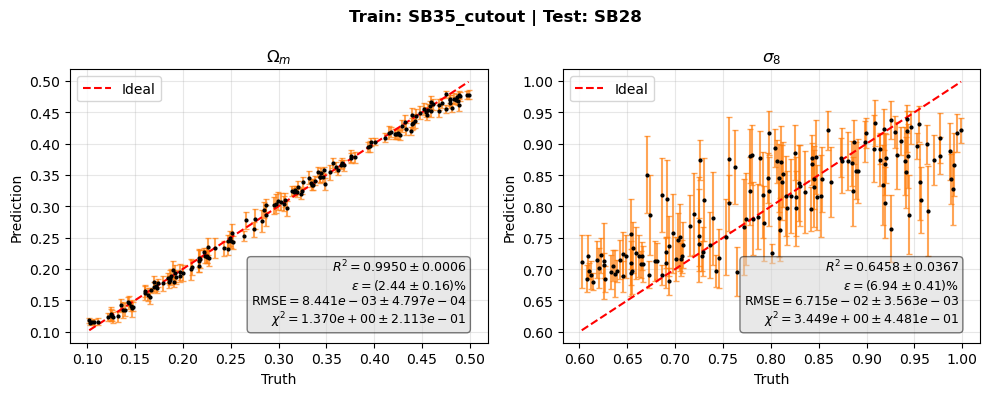

In [13]:
# 6a. SB28 model on SB35_cutout (window + crop, normalize with SB28 stats)
data_cutout = _apply_sb35_windowing(_dataSB35)
data_cutout = _apply_crop(data_cutout, crop="tl")
data_norm, _ = log_normalize(data_cutout, individual=individual, ref_stats=statsSB28)
del data_cutout

val_loader = make_test_loader(data_norm, labelsSB35, chunk_size=chunk_sb35_cutout)
model_om, model_sig = load_model_pair(
    model_dir + "SB28_om_best.pt",
    model_dir + "SB28_sig_best.pt",
    input_shape=(256, 256))

result = run_evaluation(model_om, model_sig, val_loader, minmaxSB28, chunk_sb35_cutout, "Train: SB28 | Test: SB35_cutout", save_dir=plots_dir, base_name="sb28_to_sb35cutout")
all_results.append(("SB28 → SB35_cutout", result))

del data_norm, val_loader, model_om, model_sig
clear_memory()

# 6b. SB35_cutout model on SB28 (normalize with SB35_cutout stats)
_data, _labels, _ = loadCAMELS(field="Mtot", box="SB28", normalization=False, individual=individual)
labels = torch.tensor(_labels[:, :2], dtype=dtype)
data_norm, _ = log_normalize(_data, individual=individual, ref_stats=statsSB35_cutout)
del _data, _labels

val_loader = make_test_loader(data_norm, labels, chunk_size=chunk_sb28)
result = run_evaluation(model_SB35cutout_om, model_SB35cutout_sig, val_loader, minmaxSB35, chunk_sb28, "Train: SB35_cutout | Test: SB28", save_dir=plots_dir, base_name="sb35cutout_to_sb28")
all_results.append(("SB35_cutout → SB28", result))

del data_norm, val_loader
clear_memory()

## 7. Cross-Domain: SB28_full ↔ SB35_cutout


Train: SB28_full | Test: SB35_cutout
  MSE: Om=1.2328e-04, Sig8=5.9334e-03


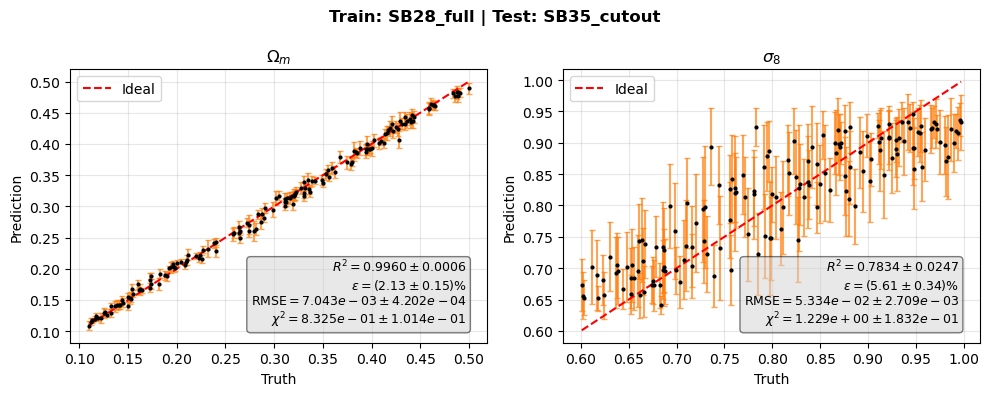


Train: SB35_cutout | Test: SB28_full
  MSE: Om=1.6631e-04, Sig8=6.1986e-03


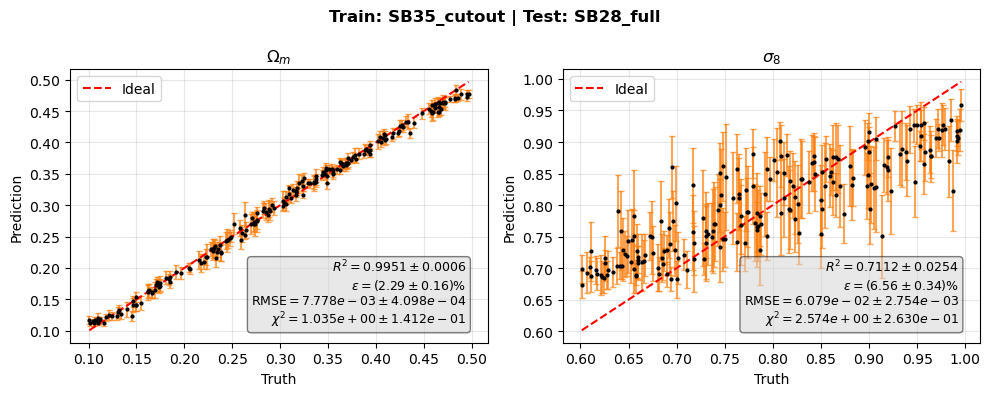

In [14]:
# 7a. SB28_full model on SB35_cutout (window + crop, normalize with SB28_full stats)
data_cutout = _apply_sb35_windowing(_dataSB35)
data_cutout = _apply_crop(data_cutout, crop="tl")
data_norm, _ = log_normalize(data_cutout, individual=individual, ref_stats=statsSB28full)
del data_cutout

val_loader = make_test_loader(data_norm, labelsSB35, chunk_size=chunk_sb35_cutout)
model_om, model_sig = load_model_pair(
    model_dir + "SB28_full_om_best.pt",
    model_dir + "SB28_full_sig_best.pt",
    input_shape=(256, 256))

result = run_evaluation(model_om, model_sig, val_loader, minmaxSB28full, chunk_sb35_cutout, "Train: SB28_full | Test: SB35_cutout", save_dir=plots_dir, base_name="sb28full_to_sb35cutout")
all_results.append(("SB28_full → SB35_cutout", result))

del data_norm, val_loader, model_om, model_sig
clear_memory()

# 7b. SB35_cutout model on SB28_full (normalize with SB35_cutout stats)
_data, _labels, _ = loadCAMELS(field="Mtot", box="SB28_full", normalization=False, individual=individual)
labels = torch.tensor(_labels[:, :2], dtype=dtype)
data_norm, _ = log_normalize(_data, individual=individual, ref_stats=statsSB35_cutout)
del _data, _labels

val_loader = make_test_loader(data_norm, labels, chunk_size=chunk_sb28)
result = run_evaluation(model_SB35cutout_om, model_SB35cutout_sig, val_loader, minmaxSB35, chunk_sb28, "Train: SB35_cutout | Test: SB28_full", save_dir=plots_dir, base_name="sb35cutout_to_sb28full")
all_results.append(("SB35_cutout → SB28_full", result))

# Final cleanup
del data_norm, val_loader, model_SB35cutout_om, model_SB35cutout_sig, _dataSB35
clear_memory()

In [15]:
# Print and save summary table
def _pm(m, s, fmt):
    if m is None or s is None:
        return 'nan'
    if not np.isfinite(m) or not np.isfinite(s):
        return 'nan'
    return (fmt.format(m) + ' ± ' + fmt.format(s))

_ensure_dir(tables_dir)
lines = []
lines.append("=" * 110)
lines.append('SUMMARY (same metrics as score box)')
lines.append("=" * 110)
header = f"{'Experiment':<30} {'Target':<6} {'R^2':>18} {'epsilon[%]':>18} {'RMSE':>18} {'chi2_nu':>18}"
lines.append(header)
lines.append('-' * 110)

print("\n" + "=" * 110)
print('SUMMARY (same metrics as score box)')
print("=" * 110)
print(header)
print('-' * 110)
for name, stats in all_results:
    for tag, label in [('om', 'Om'), ('sig', 'Sig8')]:
        r2 = _pm(stats.get(f'r2_{tag}_m'), stats.get(f'r2_{tag}_s'), '{:.4f}')
        eps = _pm(stats.get(f'eps_{tag}_pct_m'), stats.get(f'eps_{tag}_pct_s'), '{:.2f}') + '%'
        rmse = _pm(stats.get(f'rmse_{tag}_m'), stats.get(f'rmse_{tag}_s'), '{:.3e}')
        chi2 = _pm(stats.get(f'chi2_{tag}_m'), stats.get(f'chi2_{tag}_s'), '{:.3e}')
        row = f"{name:<30} {label:<6} {r2:>18} {eps:>18} {rmse:>18} {chi2:>18}"
        print(row)
        lines.append(row)
    print('-' * 110)
    lines.append('-' * 110)

summary_txt = "\n".join(lines)
with open(tables_dir / "summary.txt", "w") as f:
    f.write(summary_txt)

# Also save TSV for easy loading
tsv_lines = []
tsv_lines.append("Experiment\tTarget\tR2\tR2_std\tepsilon_pct\tepsilon_pct_std\tRMSE\tRMSE_std\tchi2_nu\tchi2_nu_std")
for name, stats in all_results:
    for tag, label in [('om', 'Om'), ('sig', 'Sig8')]:
        r2m, r2s = stats.get(f'r2_{tag}_m'), stats.get(f'r2_{tag}_s')
        epsm, epss = stats.get(f'eps_{tag}_pct_m'), stats.get(f'eps_{tag}_pct_s')
        rmsem, rmses = stats.get(f'rmse_{tag}_m'), stats.get(f'rmse_{tag}_s')
        chi2m, chi2s = stats.get(f'chi2_{tag}_m'), stats.get(f'chi2_{tag}_s')
        tsv_lines.append(
            f"{name}\t{label}\t{r2m}\t{r2s}\t{epsm}\t{epss}\t{rmsem}\t{rmses}\t{chi2m}\t{chi2s}"
        )
with open(tables_dir / "summary.tsv", "w") as f:
    f.write("\n".join(tsv_lines))


SUMMARY (same metrics as score box)
Experiment                     Target                R^2         epsilon[%]               RMSE            chi2_nu
--------------------------------------------------------------------------------------------------------------
SB28 → SB28                    Om        0.9960 ± 0.0005       2.32 ± 0.18% 7.467e-03 ± 3.816e-04 1.343e+00 ± 2.909e-01
SB28 → SB28                    Sig8      0.6640 ± 0.0375       6.57 ± 0.37% 6.538e-02 ± 3.542e-03 2.465e+00 ± 2.471e-01
--------------------------------------------------------------------------------------------------------------
SB28_full → SB28_full          Om        0.9975 ± 0.0002       1.86 ± 0.09% 5.765e-03 ± 1.948e-04 8.325e-01 ± 7.565e-02
SB28_full → SB28_full          Sig8      0.7817 ± 0.0202       5.37 ± 0.26% 5.275e-02 ± 2.203e-03 1.291e+00 ± 1.093e-01
--------------------------------------------------------------------------------------------------------------
SB35 → SB35                    Om   